In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [3]:
# deck = 'KH_Lv1di/'
# deck = 'KH_new/'
# deck = 'KH_400ppc_200wci2/'
deck = 'KH_200ppc_200wci/'
# deck = 'KH_beta0.1/'
# deck = 'turb2/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx_de = info['Lx/de']
ly_de = info['Ly/de']

lx_di = info['Lx/di']
ly_di = info['Ly/di']

nx = int(info['nx'])
ny = int(info['ny'])

lxr_di = np.linspace(0, lx_di, nx)
lyr_di = np.linspace(0, ly_di, ny)

lxr_de = np.linspace(0, lx_de, nx)
lyr_de = np.linspace(0, ly_de, ny)

In [4]:
t = times[1087]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])

150.12209160000003


In [5]:
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])

dex = ds['ex'] - np.mean(ds['ex'])
dey = ds['ey'] - np.mean(ds['ey'])
dez = ds['ez'] - np.mean(ds['ez'])

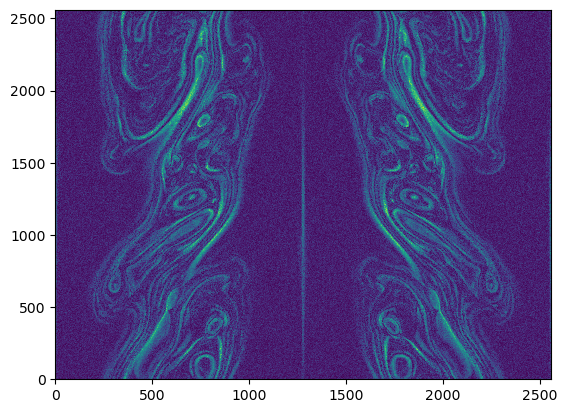

In [6]:
def flip2D(var):
  # var_flip = np.flip(var, axis = 0)
  var_flip = np.flip(var, axis = 0)
  var_per = np.concatenate((var, var_flip))
  return var_per

dsi = tb.load_vars(dirs, t, 'ion')
jz_per = flip2D(ds['jz'] + dsi['jz'])
jx = (ds['jx'] + dsi['jx'])
jy = (ds['jy'] + dsi['jy'])
jz = (ds['jz'] + dsi['jz'])
j = np.sqrt(jx**2 + jy**2 + jz**2)
j_per = flip2D(j)
plt.pcolormesh(j_per.T)

In [7]:
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)

In [8]:
%load_ext cython

In [9]:
import numpy as np
import numpy.fft as nf

def PerpSpectrum(ar,sumax=2,lenx=2*np.pi,leny=2*np.pi,lenz=2*np.pi):
   """
      PerpSpectrum(ar,sumax=2,lenx=2*pi,leny=2*pi,lenz=2*pi)
      ar -> Array to compute the spectrum
      sumax -> Axis of magnetic field direction. Right now only x,y,z = 0,1,2
      lenx,leny,lenz -> System size in x,y,z directions to take into
                        account the anisotropy of system if any

      RETURNS:
      kk -> Wavenumber array
      fekp -> Spectrum of the array
   """
   if len(ar) == 0:
      print('No array provided! Exiting!')
      return
   ar=ar-np.mean(ar)
   nx=np.shape(ar)[0];kx=nf.fftshift(nf.fftfreq(nx))*nx*(2*np.pi/lenx)
   ny=np.shape(ar)[1];ky=nf.fftshift(nf.fftfreq(ny))*ny*(2*np.pi/leny)
 
   far = nf.fftshift(nf.fftn(ar))/(nx*ny); fftea=0.5*np.abs(far)**2
   ffteb = fftea
## DEFINE A TEMPORARY XY PLANE
   if sumax==2:
      nnx=nx; nny=ny
      kkx=kx; kky=ky
## DEFINE THE KPERP VALUES AND CORRESPONDING SPECTRUM
   fekp=np.zeros(min(nnx//2,nny//2))
   kp=np.zeros((nnx,nny))
   for x in range(nnx):
      for y in range(nny):
         kp[x,y]=np.sqrt(kkx[x]**2+kky[y]**2)
   if nnx == 1:
      dk=np.abs(kp[0,1]-kp[0,0])
      kk=kp[0,nny//2:]
   elif nny == 1:
      dk=np.abs(kp[1,0]-kp[0,0])
      kk=kp[nnx//2:,0]
   else:
      dk=np.abs(kp[1,0]-kp[0,0])
      kk=kp[nnx//2,nny//2:]

   for i in range(len(fekp)):
      fekp[i]= np.sum(np.ma.MaskedArray(ffteb, ~((kp[nx//2,i+ny//2]-dk < kp) & (kp < kp[nx//2,i+ny//2]+dk))))

   return kk,fekp/dk

In [10]:

%%cython
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt
from scipy.fft import fftn, fftshift, fftfreq

# Define function with Cython typing
def PerpSpectrum2(cnp.ndarray[cnp.float64_t, ndim=2] ar, int sumax=2, 
                 double lenx=2*np.pi, double leny=2*np.pi, double lenz=2*np.pi):
    """
    Computes the perpendicular spectrum of a 2D array using FFT.
    Optimized using Cython.
    """
    if ar.size == 0:
        print('No array provided! Exiting!')
        return None, None
    
    # Remove mean from array
    ar = ar - np.mean(ar)
    
    cdef int nx = ar.shape[0]
    cdef int ny = ar.shape[1]
    
    cdef cnp.ndarray[cnp.float64_t, ndim=1] kx = fftshift(fftfreq(nx)) * nx * (2 * np.pi / lenx)
    cdef cnp.ndarray[cnp.float64_t, ndim=1] ky = fftshift(fftfreq(ny)) * ny * (2 * np.pi / leny)
    
    cdef cnp.ndarray[cnp.complex128_t, ndim=2] far = fftshift(fftn(ar)) / (nx * ny)
    cdef cnp.ndarray[cnp.float64_t, ndim=2] fftea = 0.5 * np.abs(far) ** 2
    
    cdef int nnx, nny
    cdef cnp.ndarray[cnp.float64_t, ndim=1] kkx, kky
    
    if sumax == 2:
        nnx = nx; nny = ny
        kkx = kx; kky = ky
    
    cdef cnp.ndarray[cnp.float64_t, ndim=1] fekp = np.zeros(min(nnx//2, nny//2), dtype=np.float64)
    cdef cnp.ndarray[cnp.float64_t, ndim=2] kp = np.zeros((nnx, nny), dtype=np.float64)
    
    cdef int x, y, i
    for x in range(nnx):
        for y in range(nny):
            kp[x, y] = sqrt(kkx[x]**2 + kky[y]**2)
    
    cdef double dk = abs(kp[1, 0] - kp[0, 0])
    cdef cnp.ndarray[cnp.float64_t, ndim=1] kk = kp[nnx//2, nny//2:].copy()
    
    cdef double sum_value
    for i in range(len(fekp)):
        sum_value = 0.0
        for x in range(nnx):
            for y in range(nny):
                if kp[x, y] >= kp[nx//2, i+ny//2] - dk and kp[x, y] < kp[nx//2, i+ny//2] + dk:
                    sum_value += fftea[x, y]
        fekp[i] = sum_value
    
    return kk, fekp / dk


In [11]:
def Euspec_prep(tin):
  t = times[tin]
  print(twci[tin])
  ds = tb.load_hydro_fil(dirs, t, 'ion')

  ux = ds['jx']/ds['rho']
  uy = ds['jy']/ds['rho']
  uz = ds['jz']/ds['rho']

  dux = ux - np.mean(ux)
  duy = uy - np.mean(uy)
  duz = uz - np.mean(uz)

  dux = flip2D(dux)
  duy = flip2D(duy)
  duz = flip2D(duz)
  # k, fft = tb.EuSpec2D(dux, duy, duz, lx = lx_de, ly = ly_de)
  k, fftx = PerpSpectrum(dux, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum(duy, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum(duz, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

def Ebspec_prep(tin):
  t = times[tin]
  ds = tb.load_fields(dirs, t)
  print(twci[tin])
  dbx = ds['cbx'] - np.mean(ds['cbx'])
  dby = ds['cby'] - np.mean(ds['cby'])
  dbz = ds['cbz'] - np.mean(ds['cbz'])
  dex = ds['ex'] - np.mean(ds['ex'])
  dey = ds['ey'] - np.mean(ds['ey'])
  dez = ds['ez'] - np.mean(ds['ez'])
  dbx_per = flip2D(dbx)
  dby_per = flip2D(dby)
  dbz_per = flip2D(dbz)
  # dex_per = flip2D(dex)
  # dey_per = flip2D(dey)
  # dez_per = flip2D(dez)
  # k, fft = tb.EbSpec2D(dbx_per, dby_per, dbz_per, dex_per, dey_per, dez_per, lx = lx_de, ly = ly_de)
  # PerpSpectrum(ar,sumax=2,lenx=2*np.pi,leny=2*np.pi,lenz=2*np.pi):
  k, fftx = PerpSpectrum(dbx_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum(dby_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum(dbz_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

In [12]:
def Euspec_prep2(tin):
  t = times[tin]
  print(twci[tin])
  ds = tb.load_hydro_fil(dirs, t, 'ion')

  ux = ds['jx']/ds['rho']
  uy = ds['jy']/ds['rho']
  uz = ds['jz']/ds['rho']

  dux = ux - np.mean(ux)
  duy = uy - np.mean(uy)
  duz = uz - np.mean(uz)

  dux = flip2D(dux)
  duy = flip2D(duy)
  duz = flip2D(duz)
  # k, fft = tb.EuSpec2D(dux, duy, duz, lx = lx_de, ly = ly_de)
  k, fftx = PerpSpectrum2(dux, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum2(duy, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum2(duz, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

def Ebspec_prep2(tin):
  t = times[tin]
  ds = tb.load_fields(dirs, t)
  print(twci[tin])
  dbx = ds['cbx'] - np.mean(ds['cbx'])
  dby = ds['cby'] - np.mean(ds['cby'])
  dbz = ds['cbz'] - np.mean(ds['cbz'])
  dex = ds['ex'] - np.mean(ds['ex'])
  dey = ds['ey'] - np.mean(ds['ey'])
  dez = ds['ez'] - np.mean(ds['ez'])
  dbx_per = flip2D(dbx)
  dby_per = flip2D(dby)
  dbz_per = flip2D(dbz)
  # dex_per = flip2D(dex)
  # dey_per = flip2D(dey)
  # dez_per = flip2D(dez)
  # k, fft = tb.EbSpec2D(dbx_per, dby_per, dbz_per, dex_per, dey_per, dez_per, lx = lx_de, ly = ly_de)
  # PerpSpectrum(ar,sumax=2,lenx=2*np.pi,leny=2*np.pi,lenz=2*np.pi):
  k, fftx = PerpSpectrum2(dbx_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum2(dby_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum2(dbz_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

In [17]:
dbx = ds['cbx'] - np.mean(ds['cbx'])
dbx_per = np.array(flip2D(dbx), dtype = 'd')
k, fftx = PerpSpectrum(dbx_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])

In [13]:
dbx = ds['cbx'] - np.mean(ds['cbx'])
dbx_per = np.array(flip2D(dbx), dtype = 'd')
k, fftx = PerpSpectrum2(dbx_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])

In [14]:
# uk0, ufft0 = Euspec_prep(100)

In [15]:
# uk2, ufft2 = Euspec_prep2(100)

In [16]:
plt.loglog(ufft0)

NameError: name 'ufft0' is not defined

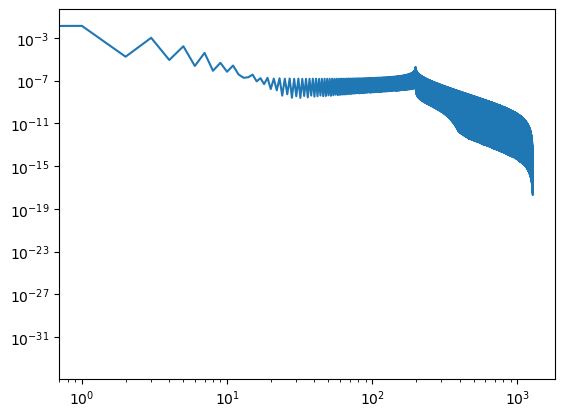

In [ ]:
plt.loglog(ufft2)